In [34]:
import numpy as np
import pandas as pd
from collections.abc import Iterable

import geopandas as gp
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyproj;  

import urllib
import json
import pickle

import time
from ipypb import track
import sys
import warnings
import os

from hlp import browse_site

### Set directories

In [2]:
os.chdir("E:/University College London/O'Sullivan, Aidan - SDG6/")
s_path = './Landsat data/Scenes/'
c1_path = "./Landsat data/Cropped level 1 data/"

### Read in list of sites for download and setup metadata

In [3]:
sites = pd.read_pickle("sites3.p").set_index(['sid','dt'])
sites = sites.set_geometry('geometry_poly')

### Cropper function

In [4]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

### Filter sites for download

In [5]:
### Filter sites and dates for those with scenes
dll = sites[sites.display_id.notna()]

### Filter sites for those with geometry
dll = dll[dll.geometry_poly.notna()].set_geometry('geometry_poly')

len(dll)

221557

### Flag already downloaded files

In [6]:
## check directory
os.getcwd()

"E:\\University College London\\O'Sullivan, Aidan - SDG6"

In [6]:
dl_files = os.listdir(c1_path)

dll['downloaded'] = pd.Series(np.bool)

for sid in track(dll.index.get_level_values(0).unique()):
                 
    sid_files = [ i for i in dl_files if sid in i ]
    
    sitedl = dll.loc[sid,:]
    
    if len([ i for i in sid_files if 'BQA' in i ])<len(sitedl):
        dll.loc[sid,'downloaded'] = False
    else:
        dll.loc[sid,'downloaded'] = True

f'number of images downloaded: {len(dll[dll.downloaded==True])}'

 [████████████████████████████████████████████████████████████] 13175/13175 [03:21<00:00, 0.02s/it]

### Open crop and save rasters from Google open API

In [49]:
## create list of scenes to download
dsids = list(dll[dll.display_id.notna()].display_id.unique())
len(dsids)

19652

In [70]:
## set crop buffer distance (300m) in degrees
bbox_bufd = 360*300/(40000*1000)

## create bands and metadata lists
bands_5 = ['B1','B2','B3','B4','B5','BQA','B6']
bands_7 = ['B1','B2','B3','B4','B5','BQA','B6_VCID_1','B6_VCID_2']
bands_8 = ['B2','B3','B4','B5','BQA','B10','B11']

meta_file_5 = ['MTL','ANG']
meta_file_7 = ['MTL','ANG','GCP']
meta_file_8 = ['MTL','ANG']

## list for exceptions
crop_exceptions = [pd.read_csv('./Landsat data/crop_exceptions.csv')]
source_exceptions = [pd.read_csv('./Landsat data/source_exceptions.csv')]
meta_exceptions = [pd.read_csv('./Landsat data/meta_exceptions.csv')]

for dsid in track([ i for i in dsids if 'LC08' in i][0:527]):
    
    #~~~~ TIF download ~~~~#
    
    sitesdl = dll[dll.display_id==dsid]
    
    if 'LT05' in dsid:
        zip_list = list(zip(bands_5,[dsid]*len(bands_5)))               
    elif 'LE07' in dsid:
        zip_list = list(zip(bands_7,[dsid]*len(bands_7)))
    elif 'LC08' in dsid:
        zip_list = list(zip(bands_8,[dsid]*len(bands_8)))
    
    ## open scene for each band in turn
    for band,dsid in zip_list:

        ## create url elements
        platform = dsid[0:4]
        key = dsid[10:13]+'/'+dsid[13:16]

        ## TIF construct source url
        filepath = f'https://storage.googleapis.com/gcp-public-data-landsat/{platform}/01/{key}/{dsid}/{dsid}_{band}.TIF'

        with rio.open(filepath) as src:
            
            ## loop through sites with that scene
            for sid in sitesdl.index.get_level_values(0):
                
                ## subset site list for site
                sitedl = sitesdl.loc[sid,:]

                ## setup polygon for cropping
                polygon_bbox = sitedl.envelope.buffer(bbox_bufd)                      
            
                polygon_bbox = polygon_bbox.to_crs(src.crs)
                polygon_geom = polygon_bbox.geometry
                

                try:

                    cropped = cropper(src, polygon_geom, c1_path+sid+'__'+dsid+'_'+band+'.TIF')            

                except:
                    crop_exceptions.append(dsid+band)
                    print(f'Crop exception for {dsid} {band}')


            src.close()

        time.sleep(1)
        
    #~~~~ metadata download ~~~~#
    
    if 'LT05' in dsid:
        mzip_list = list(zip(meta_file_5,[dsid]*len(meta_file_5)))               
    elif 'LE07' in dsid:
        mzip_list = list(zip(meta_file_7,[dsid]*len(meta_file_7)))  
    elif 'LC08' in dsid:
        mzip_list = list(zip(meta_file_8,[dsid]*len(meta_file_8)))  
        
    for mf,dsid in mzip_list:

        ## create url elements
        platform = dsid[0:4]
        key = dsid[10:13]+'/'+dsid[13:16]

        ## Metadata construct source url
        filepath = f'https://storage.googleapis.com/gcp-public-data-landsat/{platform}/01/{key}/{dsid}/{dsid}_{mf}.txt'

        try:

            ## MTL file
            remote_file = urllib.request.urlopen(filepath).read()

            local_file = open(c1_path+dsid+'_'+mf+'.txt','wb')
            local_file.write(remote_file)
            local_file.close()

        except:
            meta_exceptions.append(dsid)

            time.sleep(1)

            print(f'Scene meta not available {dsid}')

pd.Series(meta_exceptions).to_csv('./Landsat data/meta_exceptions.csv')
pd.Series(crop_exceptions).to_csv('./Landsat data/crop_exceptions.csv')
pd.Series(source_exceptions).to_csv('./Landsat data/source_exceptions.csv')    

 [████████████████████████████████████████████████████████████] 527/527 [12:27:32<00:30, 85.11s/it]

Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B2
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B3
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B4
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B5
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 BQA
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B10
Crop exception for LC08_L1TP_042029_20130605_20170310_01_T1 B11
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B2
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B3
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B4
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B5
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 BQA
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B10
Crop exception for LC08_L1TP_042029_20160528_20170223_01_T1 B11
Crop exception for LC08_L1TP_042029_20160715_20170222_01_T1 B2
Crop exception for LC08_L1TP_042029_20160715_2017

Crop exception for LC08_L1TP_013029_20150819_20170310_01_T1 B11
Crop exception for LC08_L1TP_013029_20150819_20170310_01_T1 B11
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B2
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B2
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B3
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B3
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B4
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B4
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B5
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B5
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 BQA
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 BQA
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B10
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B10
Crop exception for LC08_L1TP_013030_20170418_20170501_01_T1 B11
Crop exception for LC08_L1TP_013030_20170418_201

Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B4
Crop exception for LC08_L1TP_013028_20170723_20180125_01_T1 B5
Crop exception for LC08_L1TP_013028_20170723_20180125_0

Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B3
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B4
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B4
Crop exception for LC08_L1TP_013028_20130423_20170310_01_T1 B4
Crop exception for LC08_L1TP_013028_20130423_20170310_0

Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 BQA
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 BQA
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 BQA
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 BQA
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B10
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B10
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B10
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B10
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B11
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B11
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B11
Crop exception for LC08_L1TP_013028_20150904_20170225_01_T1 B11
Crop exception for LC08_L1TP_013028_20160720_20170222_01_T1 B2
Crop exception for LC08_L1TP_013028_20160720_20170222_01_T1 B2
Crop exception for LC08_L1TP_013028_20160720_20170222_01_T1 B3
Crop exception for LC08_L1TP_013028_2016072

In [71]:
filepath

'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/021/036/LC08_L1TP_021036_20170731_20170801_01_RT/LC08_L1TP_021036_20170731_20170801_01_RT_ANG.txt'

### Checkout individual site

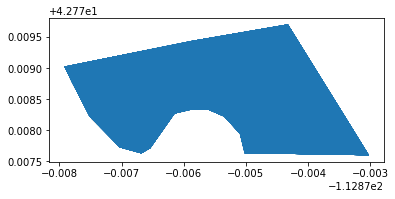

In [36]:
browse_site(sites,'1119USBR_WQX-AFE009')